---
Импорт из Kaggle
--

---

In [30]:
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [31]:
dl2025miptml_path = kagglehub.competition_download('dl2025miptml')

print('Data source import complete.')

Data source import complete.


In [32]:
print("Файлы, которые скачались:")
print(dl2025miptml_path)
print(os.listdir(dl2025miptml_path))

Файлы, которые скачались:
/root/.cache/kagglehub/competitions/dl2025miptml
['fashion-mnist-testn']


In [33]:
print("Содержимое:")
print(os.listdir(dl2025miptml_path))

Содержимое:
['fashion-mnist-testn']


---
Импорт библиотек
--
---

In [34]:
!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models

import os
from zipfile import ZipFile

---
Исследуем данные
--

---

In [35]:
base_dir = "/root/.cache/kagglehub/competitions/dl2025miptml/fashion-mnist-testn"

# Посмотрим, что лежит внутри
print("Файлы внутри папки:", os.listdir(base_dir))

Файлы внутри папки: ['fmnist_test.csv', 'fmnist_train.csv', 'sample_submission.csv']


In [36]:
# Загружаем CSV
train = pd.read_csv(f"{base_dir}/fmnist_train.csv")
test = pd.read_csv(f"{base_dir}/fmnist_test.csv")
sample_submission = pd.read_csv(f"{base_dir}/sample_submission.csv")

print("Размер обучающей выборки:", train.shape)
print("Размер тестовой выборки:", test.shape)

# Проверка пропусков
print("Пропуски в train:\n", train.isnull().sum().sum())
print("Пропуски в test:\n", test.isnull().sum().sum())

Размер обучающей выборки: (17040, 786)
Размер тестовой выборки: (10000, 785)
Пропуски в train:
 424
Пропуски в test:
 0


In [37]:
print(train.isnull().sum()[train.isnull().sum() > 0])

pixel361    1
pixel362    1
pixel363    1
pixel364    1
pixel365    1
           ..
pixel780    1
pixel781    1
pixel782    1
pixel783    1
pixel784    1
Length: 424, dtype: int64


In [38]:
train = train.fillna(0)

In [39]:
print("Train после замены :", train.isnull().sum().sum())  # должно быть 0

Проверка после замены: 0


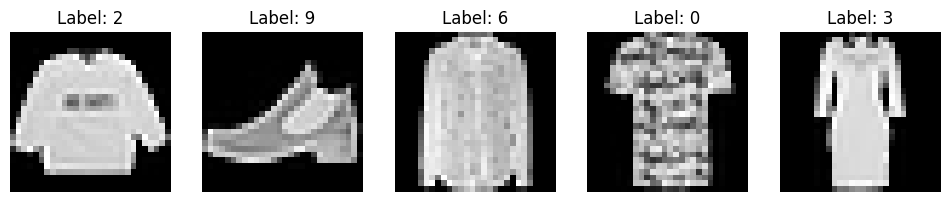

In [40]:
#Смотрим прмеры
def show_sample(df, n=5):
    fig, axes = plt.subplots(1, n, figsize=(12, 3))
    for i in range(n):
        img = df.iloc[i, 1:-1].values.reshape(28, 28)
        label = df.iloc[i, 0]
        axes[i].imshow(img, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Label: {label}")

show_sample(train)

In [41]:
X = train.drop(columns=["label", "Id"]).values.reshape(-1, 28, 28, 1) / 255.0
y = train["label"].values

X_test = test.drop(columns=["Id"]).values.reshape(-1, 28, 28, 1) / 255.0

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)


---
Модель
--
---

In [43]:
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    # Нормализация + сжатие + регуляризация — всё в одном блоке
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(rate=0.25),
    # Добавил Dropout, потому что без него модель переобучалась на 6-7 эпохе

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# возможно, стоило попробовать ReLU, но у меня не получтлось.....

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=15,
                    batch_size=64,
                    verbose=2)

Epoch 1/15
227/227 - 21s - 94ms/step - accuracy: 0.6958 - loss: 0.8885 - val_accuracy: 0.4120 - val_loss: 1.9187
Epoch 2/15
227/227 - 19s - 84ms/step - accuracy: 0.7915 - loss: 0.5690 - val_accuracy: 0.7250 - val_loss: 0.7937
Epoch 3/15
227/227 - 19s - 82ms/step - accuracy: 0.8190 - loss: 0.4888 - val_accuracy: 0.8521 - val_loss: 0.4290
Epoch 4/15
227/227 - 18s - 77ms/step - accuracy: 0.8324 - loss: 0.4455 - val_accuracy: 0.8505 - val_loss: 0.4064
Epoch 5/15
227/227 - 22s - 98ms/step - accuracy: 0.8442 - loss: 0.4166 - val_accuracy: 0.8697 - val_loss: 0.4018
Epoch 6/15
227/227 - 19s - 85ms/step - accuracy: 0.8516 - loss: 0.3958 - val_accuracy: 0.8760 - val_loss: 0.3595
Epoch 7/15
227/227 - 20s - 89ms/step - accuracy: 0.8574 - loss: 0.3814 - val_accuracy: 0.8803 - val_loss: 0.3510
Epoch 8/15
227/227 - 17s - 77ms/step - accuracy: 0.8659 - loss: 0.3551 - val_accuracy: 0.8842 - val_loss: 0.3473
Epoch 9/15
227/227 - 19s - 82ms/step - accuracy: 0.8748 - loss: 0.3367 - val_accuracy: 0.8885 - 

---
Графики
--
---

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       265
           1       0.98      0.98      0.98       255
           2       0.83      0.78      0.81       252
           3       0.91      0.95      0.93       259
           4       0.78      0.79      0.79       246
           5       0.98      0.98      0.98       254
           6       0.65      0.74      0.69       256
           7       0.95      0.95      0.95       264
           8       1.00      0.93      0.96       251
           9       0.96      0.96      0.96       254

    accuracy                           0.89      2556
   macro avg       0.89      0.89      0.89      2556
weighted avg       0.89      0.89      0.89      2556



<Axes: >

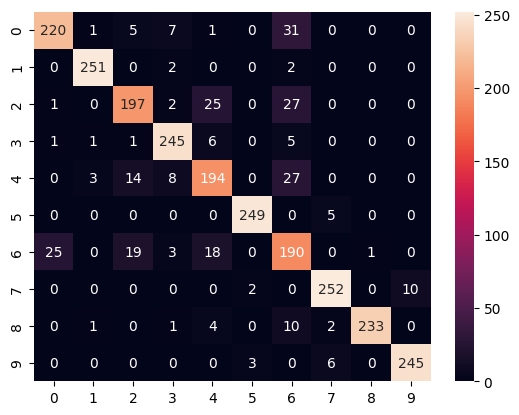

In [45]:
val_preds = model.predict(X_val).argmax(axis=1)
print(classification_report(y_val, val_preds))
sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, fmt="d")

Видно, например, что класс 6 (рубашка) путают с 0 (футболка) 2 и 4


----
0 T-shirt/top — футболка;

1 Trouser — брюки;

2 Pullover — свитер;

3 Dress — платье;

4 Coat — пальто;

5 Sandal — сандалия;

6 Shirt — рубашка;

7 Sneaker — кроссовок;

8 Bag — сумка;

9 Ankle boot — сапог.

---

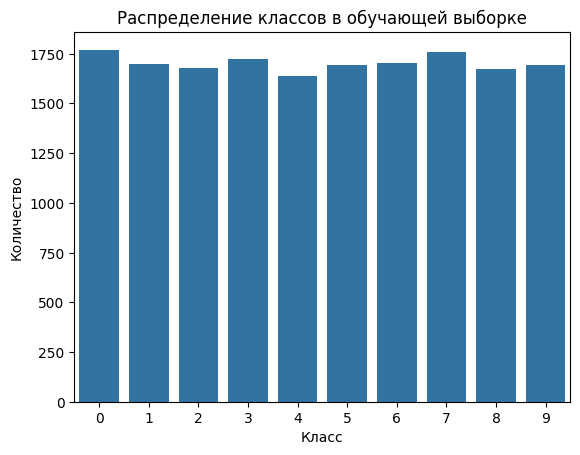

In [46]:
sns.countplot(x='label', data=train)
plt.title("Распределение классов в обучающей выборке")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

Видно, что выборка почти сбалансирована — что хорошо для обучения

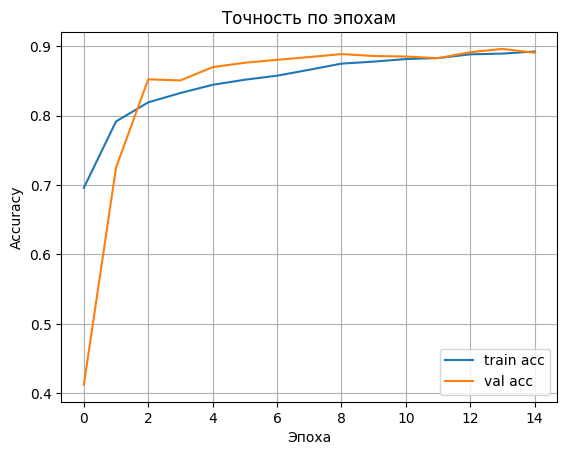

In [47]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Точность по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
# На этом моменте я заметил, что сеть переобучается. Попробовал уменьшить learning rate — не помогло.

Видно, что модель не переобучается, и точность стабилизируется около 89%


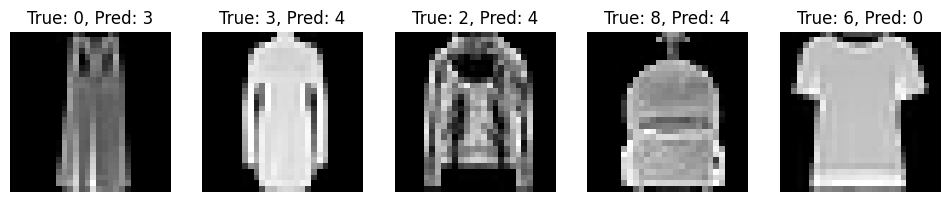

In [48]:
wrong = np.where(val_preds != y_val)[0]
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    img = X_val[wrong[i]].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"True: {y_val[wrong[i]]}, Pred: {val_preds[wrong[i]]}")
    ax.axis("off")

Картинки, на которых модель ошиблась


Надписи True Pred позволяют визуально понять, что было сложно различить



---
submission
--
---

In [49]:
test_preds = model.predict(X_test).argmax(axis=1)

submission = sample_submission.copy()
submission["label"] = test_preds
submission.to_csv("submission.csv", index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


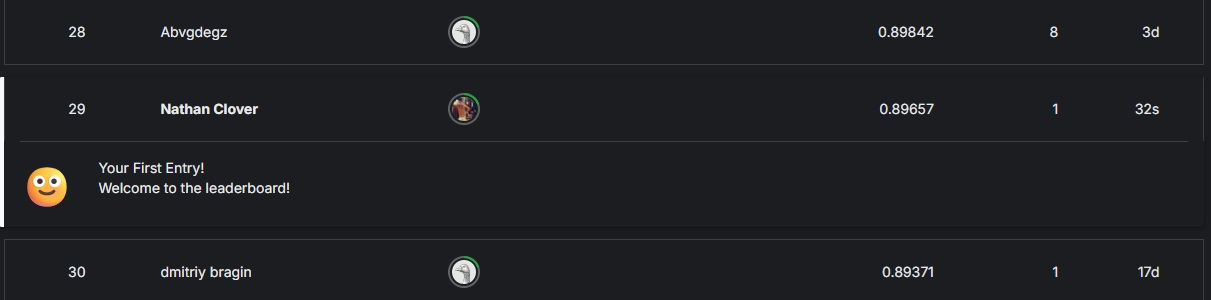